In [1]:
############################################################
# Plots of meta-stable Maxwell loops
# Inspired by https://doi.org/10.1134/S0036024406040030
# Math tricks taken from: http://math.stackexchange.com/q/416823/92706
# Plot also shown on page 79 of https://doi.org/10.15480/882.1207
############################################################

# load some bits and pieces
import numpy as np
from numpy.linalg import solve
from numpy.linalg import lstsq
from numpy import log

import matplotlib
import matplotlib.pyplot as plt

import CoolProp as CP
from CoolProp.CoolProp import PropsSI

# Check: CoolProp version
print(CP.__version__)
print(CP.__gitrevision__)

# Constants
eps = 1e-3
kilo = 1e3
Mega = 1e6
golden = (1 + 5 ** 0.5) / 2
width = 12.5

6.1.1dev
6d076f9a634cd4b0991d075bb6aa0c0aa29ed8dd


In [2]:
# Calculation of the coefficients for the metastable region interpolation happens in this cell

# Set FluidName
FluidName = 'R125'
nPoints = 1000
# pick any int smaller than nPoints
myIdx = 860 

# Constants, triple and critical data
R = PropsSI('GAS_CONSTANT',FluidName)
MM = PropsSI('MOLAR_MASS',FluidName)
Rs = R/MM
T_crt = PropsSI('T_CRITICAL',FluidName)
T_trp = PropsSI('T_TRIPLE',FluidName)
p_crt = PropsSI('P_CRITICAL',FluidName)
p_trp = PropsSI('P_TRIPLE',FluidName)
p_max = PropsSI('P_MAX',FluidName)
d_crt = PropsSI('RHOMASS_CRITICAL',FluidName)
v_crt = 1/d_crt
d_trp_liq = PropsSI('D','T',T_trp,'Q',0,FluidName)
d_trp_vap = PropsSI('D','T',T_trp,'Q',1,FluidName)
print("R = " + str(R))
print("MM = " + str(MM))
print("Rs = " + str(Rs))
print("T_crt = " + str(T_crt))
print("T_trp = " + str(T_trp))

T_sat = np.linspace(T_trp, T_crt-eps, num=nPoints)
# empty arrays
# vap side
delta_vap = np.empty(nPoints)
tau_vap = np.empty(nPoints)
p_vap = np.empty(nPoints)
d_vap = np.empty(nPoints)
v_vap = np.empty(nPoints)
f_vap = np.empty(nPoints)
dP_dD_T_vap = np.empty(nPoints)
d2P_dD2_T_vap = np.empty(nPoints)
d2P_dDdT_vap = np.empty(nPoints)
# liq side
delta_liq = np.empty(nPoints)
tau_liq = np.empty(nPoints)
p_liq = np.empty(nPoints)
d_liq = np.empty(nPoints)
v_liq = np.empty(nPoints)
f_liq = np.empty(nPoints)
dP_dD_T_liq = np.empty(nPoints)
d2P_dD2_T_liq = np.empty(nPoints)
d2P_dDdT_liq = np.empty(nPoints)
# metastable coeffs: 
AShape = (8,8)
A = np.empty(AShape)
b = np.empty(8)
xShape = (nPoints,8)
x = np.empty(xShape)

vapState = CP.AbstractState("HEOS", FluidName)
liqState = CP.AbstractState("HEOS", FluidName)
# get values from CoolProp
for idx in range(0,nPoints):
    # update states
    vapState.update(CP.QT_INPUTS, 1, T_sat[idx]) 
    liqState.update(CP.QT_INPUTS, 0, T_sat[idx])  
    
    # copy values AT the vap line 
    delta_vap[idx] = vapState.delta() 
    tau_vap[idx] = vapState.tau()
    p_vap[idx] = vapState.p()
    d_vap[idx] = vapState.rhomass()
    f_vap[idx] = Rs*T_sat[idx]*( vapState.alpha0() + vapState.alphar() )    
    #f_vap[idx] = vapState.umass() - T_sat[idx]*vapState.smass()
    dP_dD_T_vap[idx] = vapState.first_partial_deriv(CP.iP, CP.iDmass, CP.iT)
    d2P_dD2_T_vap[idx] = vapState.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iDmass, CP.iT)
    d2P_dDdT_vap[idx] = vapState.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iT, CP.iDmass)     
    
    # copy values AT the liq line
    delta_liq[idx] = liqState.delta() 
    tau_liq[idx] = liqState.tau()
    p_liq[idx] = liqState.p() 
    d_liq[idx] = liqState.rhomass() 
    f_liq[idx] = Rs*T_sat[idx]*( liqState.alpha0() + liqState.alphar() )
    # f_liq[idx] = liqState.umass() - T_sat[idx]*liqState.smass()
    dP_dD_T_liq[idx] = liqState.first_partial_deriv(CP.iP, CP.iDmass, CP.iT)
    d2P_dD2_T_liq[idx] = liqState.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iDmass, CP.iT)   
    d2P_dDdT_liq[idx] = liqState.second_partial_deriv(CP.iP, CP.iDmass, CP.iT, CP.iT, CP.iDmass)   

    # calculate metastable coeffs by solving Ax=b
    A = np.array([  [1/tau_vap[idx], -1/delta_vap[idx]/tau_vap[idx],  log(delta_vap[idx]),          delta_vap[idx],     delta_vap[idx]**2/2,       delta_vap[idx]**3/3,         delta_vap[idx]**4/4,        delta_vap[idx]**5/5 ], 
                    [1/tau_liq[idx], -1/delta_liq[idx]/tau_liq[idx],  log(delta_liq[idx]),          delta_liq[idx],     delta_liq[idx]**2/2,       delta_liq[idx]**3/3,         delta_liq[idx]**4/4,        delta_liq[idx]**5/5 ], 
                    [             0,             d_crt/tau_vap[idx], d_crt*delta_vap[idx], d_crt*delta_vap[idx]**2, d_crt*delta_vap[idx]**3,    d_crt*delta_vap[idx]**4,    d_crt*delta_vap[idx]**5,    d_crt*delta_vap[idx]**6 ], 
                    [             0,             d_crt/tau_liq[idx], d_crt*delta_liq[idx], d_crt*delta_liq[idx]**2, d_crt*delta_liq[idx]**3,    d_crt*delta_liq[idx]**4,    d_crt*delta_liq[idx]**5,    d_crt*delta_liq[idx]**6 ], 
                    [             0,                              0,                    1,        2*delta_vap[idx],     3*delta_vap[idx]**2,        4*delta_vap[idx]**3,        5*delta_vap[idx]**4,        6*delta_vap[idx]**5 ], 
                    [             0,                              0,                    1,        2*delta_liq[idx],     3*delta_liq[idx]**2,        4*delta_liq[idx]**3,        5*delta_liq[idx]**4,        6*delta_liq[idx]**5 ], 
                    [             0,                              0,                    0,                 2/d_crt,  6*delta_vap[idx]/d_crt, 12*delta_vap[idx]**2/d_crt, 20*delta_vap[idx]**3/d_crt, 30*delta_vap[idx]**4/d_crt ], 
                    [             0,                              0,                    0,                 2/d_crt,  6*delta_liq[idx]/d_crt, 12*delta_liq[idx]**2/d_crt, 20*delta_liq[idx]**3/d_crt, 30*delta_liq[idx]**4/d_crt ]])
    A = Rs*T_crt*A
    b = np.array([f_vap[idx], f_liq[idx], p_vap[idx], p_liq[idx], dP_dD_T_vap[idx], dP_dD_T_liq[idx], d2P_dD2_T_vap[idx], d2P_dD2_T_liq[idx]])
    x[idx] = solve(A,b)
    
    # for validation
    if (abs(idx-myIdx)<0.9):
        print(np.allclose(np.dot(A, x[idx]), b))
        print(A)
        print(b)
        print(x[idx])


R = 8.314472
MM = 0.1200214
Rs = 69.2749126405791
T_crt = 339.173
T_trp = 172.52
True
[[  2.18897768e+04  -8.06034729e+04  -3.06277880e+04   6.38094260e+03
    8.66447833e+02   1.56869582e+02   3.19512299e+01   6.94168888e+00]
 [  2.18897768e+04  -1.17791438e+04   1.45603294e+04   4.36641357e+04
    4.05716324e+04   5.02642066e+04   7.00563818e+04   1.04151445e+05]
 [  0.00000000e+00   1.25555879e+07   3.65999554e+06   9.93958231e+05
    2.69932833e+05   7.33066360e+04   1.99081484e+04   5.40652788e+03]
 [  0.00000000e+00   1.25555879e+07   2.50449741e+07   4.65423380e+07
    8.64919732e+07   1.60732394e+08   2.98697111e+08   5.55083901e+08]
 [  0.00000000e+00   0.00000000e+00   2.34961799e+04   1.27618852e+04
    5.19868700e+03   1.88243498e+03   6.39024598e+02   2.08250667e+02]
 [  0.00000000e+00   0.00000000e+00   2.34961799e+04   8.73282715e+04
    2.43429794e+05   6.03170479e+05   1.40112764e+06   3.12454335e+06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.19278459e+0

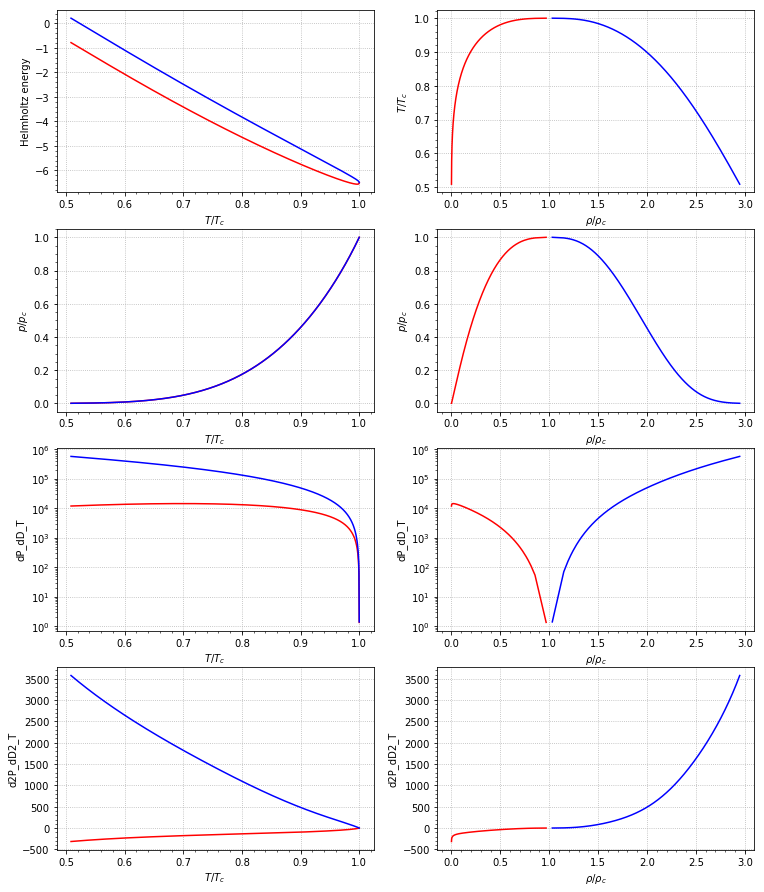

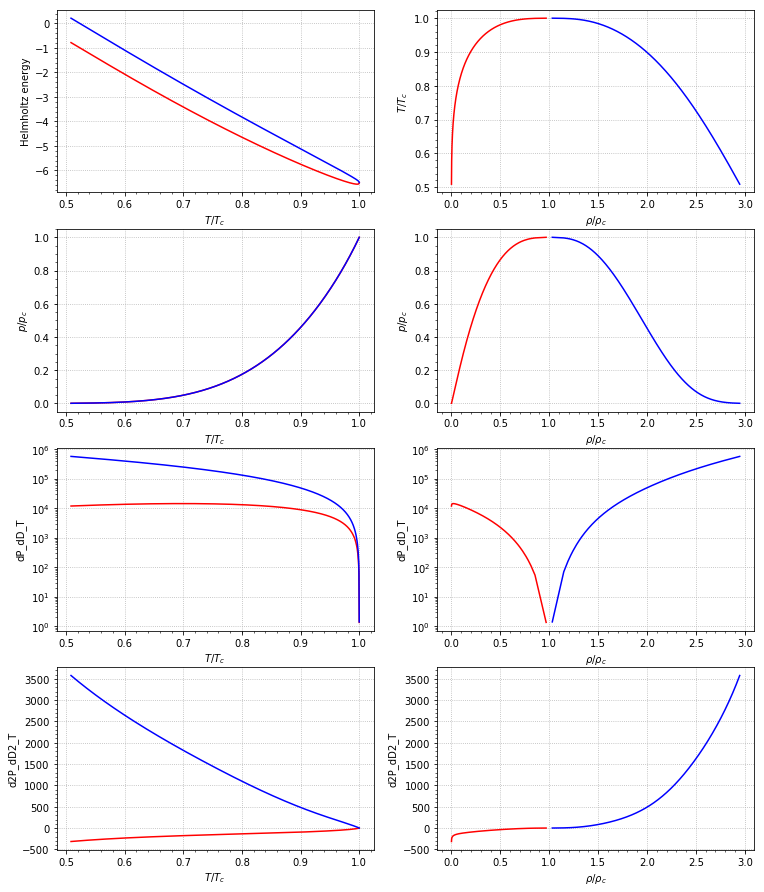

In [4]:
# Just some validation plots
plt.figure(figsize=(width,width*4/2/golden))

plt.subplot(4,2,1)
plt.plot(T_sat/T_crt, f_vap/Rs/T_sat, color='red')
plt.plot(T_sat/T_crt, f_liq/Rs/T_sat, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$T / T_c$')
plt.ylabel('Helmholtz energy')

plt.subplot(4,2,2)
plt.plot(d_vap/d_crt, T_sat/T_crt, color='red')
plt.plot(d_liq/d_crt, T_sat/T_crt, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel(r'$T / T_c$')

plt.subplot(4,2,3)
plt.plot(T_sat/T_crt, p_vap/p_crt, color='red')
plt.plot(T_sat/T_crt, p_liq/p_crt, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$T / T_c$')
plt.ylabel(r'$p / p_c$')

plt.subplot(4,2,4)
plt.plot(d_vap/d_crt, p_vap/p_crt, color='red')
plt.plot(d_liq/d_crt, p_liq/p_crt, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel(r'$p / p_c$')

plt.subplot(4,2,5)
plt.plot(T_sat/T_crt, dP_dD_T_vap, color='red')
plt.plot(T_sat/T_crt, dP_dD_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$T / T_c$')
plt.ylabel('dP_dD_T')

plt.subplot(4,2,6)
plt.plot(d_vap/d_crt, dP_dD_T_vap, color='red')
plt.plot(d_liq/d_crt, dP_dD_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel('dP_dD_T')

plt.subplot(4,2,7)
plt.plot(T_sat/T_crt, d2P_dD2_T_vap, color='red')
plt.plot(T_sat/T_crt, d2P_dD2_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$T / T_c$')
plt.ylabel('d2P_dD2_T')

plt.subplot(4,2,8)
plt.plot(d_vap/d_crt, d2P_dD2_T_vap, color='red')
plt.plot(d_liq/d_crt, d2P_dD2_T_liq, color='blue')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel('d2P_dD2_T')

plt.show()

tau_iso = 1.0733860015
T_iso = 315.984184184
p_sat(T_iso) = 2148665.30554
d_vap(T_iso) = 155.769812405
d_liq(T_iso) = 1065.91685036
coeffs = [-4.18587381 -0.00876351  1.02344077 -1.76846622  0.95090984  0.33340544
 -0.56970975  0.16802998]


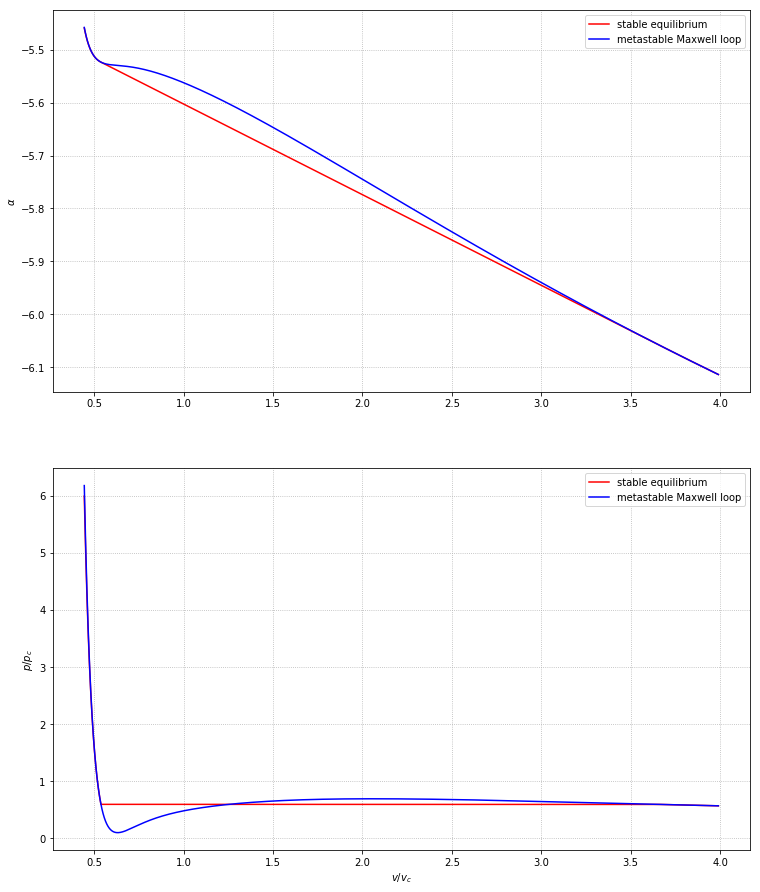

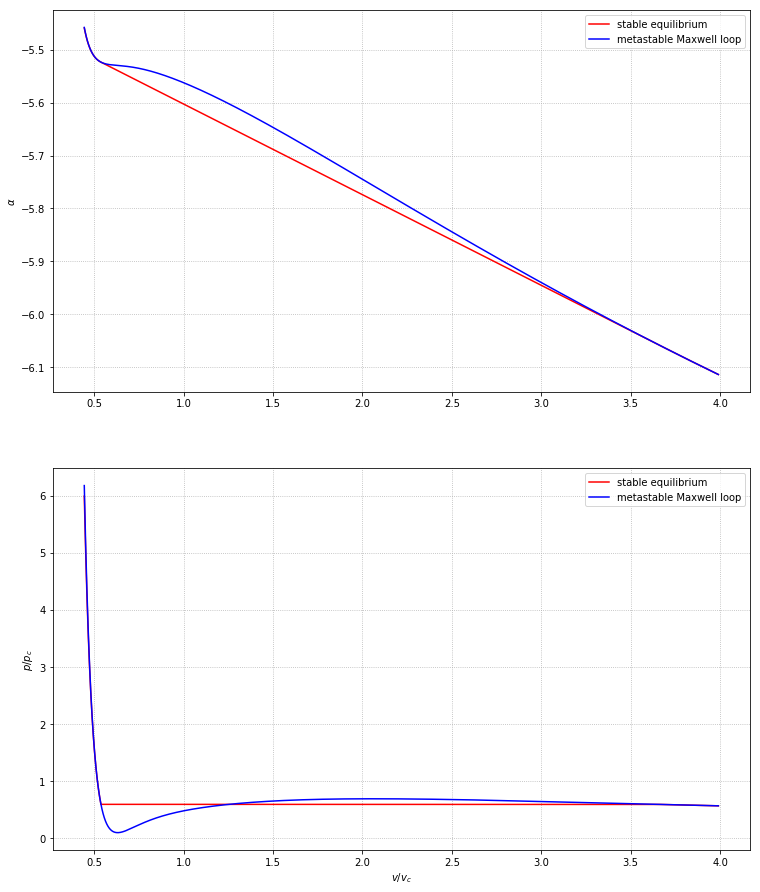

In [6]:
# This cell is for plotting the Maxwell loops along one specified isotherm (chosen with myIdx)
T_iso = T_sat[myIdx]
tau_iso = T_crt/T_iso
p_iso = p_vap[myIdx]
print("tau_iso = " + str(tau_iso))
print("T_iso = " + str(T_iso))
print("p_sat(T_iso) = " + str(p_iso))
print("d_vap(T_iso) = " + str(d_vap[myIdx]))
print("d_liq(T_iso) = " + str(d_liq[myIdx]))

# copy coeffs of that single point
c = x[myIdx,:]
print("coeffs = " + str(c))
      
# get a density range
d_min = d_crt/3.99
d_max = PropsSI('D','T',T_iso,'P',5.99*p_crt,FluidName)
rhos = np.linspace(d_min, d_max, num=nPoints)
deltas = rhos/d_crt
# for plotting, we will use volume (d_min is high v, d_max is low v)
vs = 1/rhos

# calcualte Helmholtz energy and pressure for that density range, at T_iso
fs = np.ones(nPoints)
ps = np.ones(nPoints)
fms = np.ones(nPoints)
pms = np.ones(nPoints)
dState = CP.AbstractState("HEOS", FluidName)
for idx in range(0,nPoints):
    # stable
    dState.update(CP.DmassT_INPUTS, rhos[idx], T_iso)  
    #fs[idx] = Rs*T_iso*(dState.alpha0() + dState.alphar())
    fs[idx] = dState.umass() - T_iso*dState.smass()
    ps[idx] = dState.p()
    # meta stable interpolation
    # p = -(df/dv)_T
    # s = -(df/dT)_v
    # cv = T*(ds/dT)_v = -T*(dsf/dT2)_v
    fms[idx]  = Rs*T_crt*( +c[0]/tau_iso -c[1]/tau_iso/deltas[idx] +c[2]*log(deltas[idx]) +c[3]*deltas[idx]    +c[4]*deltas[idx]**2/2 +c[5]*deltas[idx]**3/3 +c[6]*deltas[idx]**4/4 +c[7]*deltas[idx]**5/5 )
    pms[idx]  = Rs*T_crt*d_crt*( 0       +c[1]/tau_iso             +c[2]*deltas[idx]      +c[3]*deltas[idx]**2 +c[4]*deltas[idx]**3   +c[5]*deltas[idx]**4   +c[6]*deltas[idx]**5   +c[7]*deltas[idx]**6   )

# now plot 
plt.figure(figsize=(width,width*2/1/golden))

plt.subplot(2,1,1)
plt.plot(vs/v_crt, fs/Rs/T_iso, color='red', label='stable equilibrium')
plt.plot(vs/v_crt, fms/Rs/T_iso, color='blue', label='metastable Maxwell loop')
plt.grid(b=True, linestyle=':')
plt.legend(loc='upper right')
plt.ylabel(r'$\alpha$')

plt.subplot(2,1,2)
plt.plot(vs/v_crt, ps/p_crt, color='red', label='stable equilibrium')
plt.plot(vs/v_crt, pms/p_crt, color='blue', label='metastable Maxwell loop')
#plt.ylim(ymax=3)
plt.grid(b=True, linestyle=':')
plt.legend(loc='upper right')
plt.ylabel(r'$p/p_c$')
plt.xlabel(r'$v/v_c$')

plt.show()

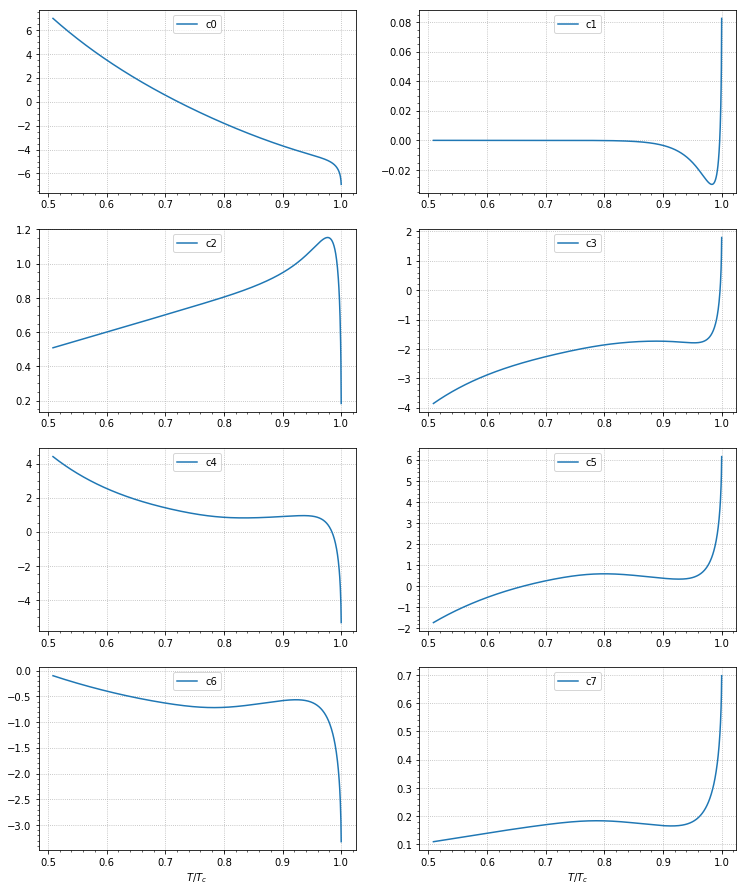

In [7]:
# copy coeffs for all points
c0 = x[:,0]
c1 = x[:,1]
c2 = x[:,2]
c3 = x[:,3]
c4 = x[:,4]
c5 = x[:,5]
c6 = x[:,6]
c7 = x[:,7]

# plot the values of all 8 coeffs over T_sat
plt.figure(figsize=(width,width*4/2/golden))

plt.subplot(4,2,1)
plt.plot(T_sat/T_crt, c0, label='c0')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,2)
plt.plot(T_sat/T_crt, c1, label='c1')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,3)
plt.plot(T_sat/T_crt, c2, label='c2')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,4)
plt.plot(T_sat/T_crt, c3, label='c3')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,5)
plt.plot(T_sat/T_crt, c4, label='c4')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,6)
plt.plot(T_sat/T_crt, c5, label='c5')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')

plt.subplot(4,2,7)
plt.plot(T_sat/T_crt, c6, label='c6')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')
plt.xlabel(r'$T / T_c$')

plt.subplot(4,2,8)
plt.plot(T_sat/T_crt, c7, label='c7')
plt.grid(b=True, linestyle=':')
plt.minorticks_on()
plt.legend(loc='upper center')
plt.xlabel(r'$T / T_c$')

plt.show()